In [3]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import ks_2samp

In [4]:
rcParams['font.family'] = 'SimHei'  # Windows 示例：可以换成你系统中的中文字体
rcParams['axes.unicode_minus'] = False  # 防止负号显示乱码

In [5]:
# get current dir
current_dir = './data'

file_list = []

for root, dirs, files in os.walk(current_dir):
    for file in files:
        if file.endswith(".mat"):
           file_list.append(file)

file_list.sort()

In [6]:
len(file_list)

114

In [7]:
L_fix = [0.03, 1]
D_fix = [4, 0.03]
R_fix = [4, 1]

L_change = [1, 1.3, 1.8, 2.3, 2.8, 3.3, 3.8, 4.3, 4.8]
D_change = [0.5, 0.8, 1.3, 1.8, 2.3]
R_change = [0.005, 0.02, 0.045, 0.07, 0.095]

angle = np.linspace(0, 180, 91)

In [8]:
L_param = np.array([[item] + L_fix for item in [item for item in L_change for _ in range(2)]])
D_param = np.array([D_fix + [item] for item in [item for item in D_change for _ in range(2)]])
R_param = np.array([[R_fix[0]]+[item]+[R_fix[1]] for item in [item for item in R_change for _ in range(2)]])

L_param = np.vstack([L_param, L_param, L_param])
D_param = np.vstack([D_param, D_param, D_param])
R_param = np.vstack([R_param, R_param, R_param])

print(L_param.shape, D_param.shape, R_param.shape)

(54, 3) (30, 3) (30, 3)


In [9]:
# number of duplicate
k = len(angle)


# list initialization
L_arr = []

# traverse every row
for row in L_param:
    # traverse every element
    for element in angle:
        new_row = np.append(row, element)
        L_arr.append(new_row)

L_arr = np.array(L_arr)

# list initialization
D_arr = []

# traverse every row
for row in D_param:
    # traverse every element
    for element in angle:
        new_row = np.append(row, element)
        D_arr.append(new_row)

D_arr = np.array(D_arr)

# list initialization
R_arr = []

# traverse every row
for row in R_param:
   # traverse every element
    for element in angle:
        new_row = np.append(row, element)
        R_arr.append(new_row)

R_arr = np.array(R_arr)

print(L_arr.shape, D_arr.shape, R_arr.shape)

(4914, 4) (2730, 4) (2730, 4)


In [10]:
channel_list = ['C']*182 + ['S']*182 + ['X']*182
channel_list = channel_list * 19
len(channel_list)

10374

In [11]:
polar_list = ['hh']*91 + ['vv']*91 
polar_list = polar_list * 57
len(polar_list)

10374

In [12]:
encoder = OneHotEncoder()
encoded_cats = encoder.fit_transform(np.hstack([np.array([channel_list]).reshape(-1, 1), np.array([polar_list]).reshape(-1, 1)]))
encoded_cats = encoded_cats.toarray()

In [13]:
nonclass_feature = np.vstack([D_arr, L_arr, R_arr])
nonclass_feature.shape

(10374, 4)

In [14]:
X_feature = np.hstack([nonclass_feature, encoded_cats])

X_feature = np.hstack([X_feature[:, :3], X_feature[:, 4:]])
# X_feature = X_feature[90::91, :]

In [15]:
# data matrix
X_feature[:5]

array([[4.  , 0.03, 0.5 , 1.  , 0.  , 0.  , 1.  , 0.  ],
       [4.  , 0.03, 0.5 , 1.  , 0.  , 0.  , 1.  , 0.  ],
       [4.  , 0.03, 0.5 , 1.  , 0.  , 0.  , 1.  , 0.  ],
       [4.  , 0.03, 0.5 , 1.  , 0.  , 0.  , 1.  , 0.  ],
       [4.  , 0.03, 0.5 , 1.  , 0.  , 0.  , 1.  , 0.  ]])

In [16]:
# data label
y_list = []

for file in file_list:
    data = scipy.io.loadmat('./data/'+ file)
    mean = data['fea_jing'][0][0][0][0][0][1].reshape(-1,)
    y_list.append(mean)

total_y = np.array(y_list).reshape(114*91, 1)
y_feature = total_y

In [17]:
y_feature.shape

(10374, 1)

In [18]:
# PAWN敏感性计算函数
def pawn_sensitivity(X, Y, num_bins=500):
    sensitivities = []
    for i in range(X.shape[1]):  # pawn sensitivity analysis on every feature
        ks_statistics = []
        
        # seperate feature i to n bins
        percentiles = np.percentile(X[:, i], np.linspace(0, 100, num_bins + 1))
        
        for j in range(num_bins):
            # acquire range of each bin
            mask = (X[:, i] >= percentiles[j]) & (X[:, i] < percentiles[j + 1])
            
            # compute conditional distribution of Y
            Y_cond = Y[mask]
            
            # compute KS distance between Y and Y_cond
            if len(Y_cond) > 0:
                ks_stat, _ = ks_2samp(Y, Y_cond)
                ks_statistics.append(ks_stat)
        
        # PAWN sensitivity is the maximum of all KS statistics
        sensitivities.append(np.max(ks_statistics))
    
    return sensitivities

In [19]:
# PAWN敏感性区间计算函数
def pawn_sensitivity_interval(X, Y, num_bins=500, bootstrap_iterations=200):
    # initialize sensitivity list
    bootstrap_results = []
    for _ in range(bootstrap_iterations):
        indices = np.random.choice(range(X_feature.shape[0]), size=X_feature.shape[0], replace=True)
        X_bootstrap = X[indices, ]
        Y_bootstrap = Y[indices]

        sensitivity = pawn_sensitivity(X_bootstrap, Y_bootstrap)
        bootstrap_results.append(sensitivity)

    return bootstrap_results
    

In [20]:
# compute PAWN sensitivity for every feature
sensitivities = pawn_sensitivity(X_feature, y_feature)

# print result
for i, sensitivity in enumerate(sensitivities):
    print(f"Feature {i + 1} - PAWN Sensitivity: {sensitivity}")

Feature 1 - PAWN Sensitivity: 0.2534220165799113
Feature 2 - PAWN Sensitivity: 0.1256988625409678
Feature 3 - PAWN Sensitivity: 0.13774821669558507
Feature 4 - PAWN Sensitivity: 0.01971274339695389
Feature 5 - PAWN Sensitivity: 0.09856371698476968
Feature 6 - PAWN Sensitivity: 0.09393676498939657
Feature 7 - PAWN Sensitivity: 0.08550221708116446
Feature 8 - PAWN Sensitivity: 0.08550221708116446


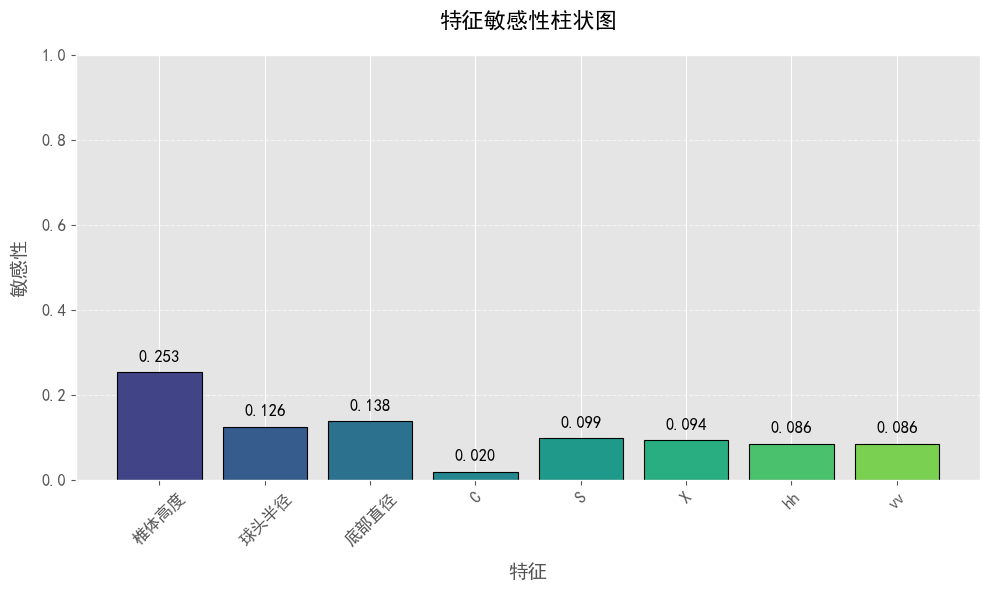

In [24]:
# Features
features = ['椎体高度', '球头半径', '底部直径', 'C', 'S', 'X', 'hh', 'vv']
values = sensitivities


plt.style.use('ggplot')  # 选择风格，可尝试 'ggplot', 'fivethirtyeight', 'seaborn'


colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(features)))


fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(features, values, color=colors, edgecolor='black', linewidth=0.8)


ax.set_title('特征敏感性柱状图', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('特征', fontsize=14, labelpad=10)
ax.set_ylabel('敏感性', fontsize=14, labelpad=10)
ax.set_ylim(0, 1)  
ax.grid(axis='y', linestyle='--', alpha=0.6)


for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.3f}', 
            ha='center', va='bottom', fontsize=12)


ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)

fig.tight_layout()

plt.show()

In [25]:
sensitivity_bootstrap = pawn_sensitivity_interval(X_feature, y_feature)

## 设置置信度水平

In [26]:
confidence_level = 0.9

In [31]:

features = ['椎体高度', '球头半径', '底部直径', 'C', 'S', 'X', 'hh', 'vv']
means = [np.quantile([item[i] for item in sensitivity_bootstrap], 0.5) for i in range(8)]  
lower_bounds = [np.quantile([item[i] for item in sensitivity_bootstrap], 1-confidence_level) for i in range(8)]  
upper_bounds = [np.quantile([item[i] for item in sensitivity_bootstrap], confidence_level) for i in range(8)]


errors = [np.array(means) - np.array(lower_bounds), 
          np.array(upper_bounds) - np.array(means)]


fig, ax = plt.subplots(figsize=(10, 6))


ax.errorbar(features, means, yerr=errors, fmt='o', 
            color='darkblue', ecolor='royalblue', elinewidth=3, capsize=5, alpha=0.9, label='90% CI')


ax.set_title('Feature Intervals with ' +str(confidence_level*100) +'% Confidence', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('特征', fontsize=14, labelpad=10)
ax.set_ylabel('敏感性区间', fontsize=14, labelpad=10)
ax.set_ylim(0, 1)  # 设置Y轴范围
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)


fig.tight_layout()


plt.show()